## Set Up

In [1]:
!nvidia-smi

Thu Nov 25 18:11:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import math
from scipy.signal.windows import triang
from scipy.signal import convolve2d as conv2


from tqdm.notebook import tqdm #progress bar

import cv2

import datetime

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.python.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split

# from segmentation_models import Unet


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
import PIL

In [5]:
pari_data = np.load('/content/drive/MyDrive/CS230 Project/Dataset /data_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['data']


pari_label = np.load('/content/drive/MyDrive/CS230 Project/Dataset /labels_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['labels']

In [5]:
print('Shape X:', pari_data.shape)
print('Shape Y:', pari_label.shape)

Shape X: (1006, 782, 590)
Shape Y: (1006, 782, 590)


## Data Augmentation

Types of augmentation:
- flip horizontal
- mild shear
- "stride"
- diff directions within cube

Create function for each augmentation. Each function needs to preserve
aspect ratio in output images.

(700, 700, 3, 1)


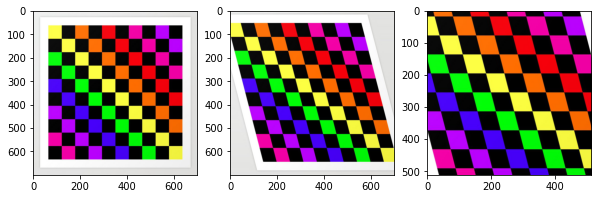

In [ ]:
# Shear demonstration - shear occurs "counterclockwise" from center of image
img = np.asarray(PIL.Image.open('/content/drive/MyDrive/reference.jpeg'))
shear_degrees = 15
fig, ax = plt.subplots(1, 3, figsize=(10,8))
datagen = ImageDataGenerator()
sample_train = np.expand_dims(img, -1)
print(sample_train.shape)
transformed = np.concatenate([np.swapaxes(datagen.apply_transform(np.swapaxes(sample_train[:, :, i], 0, 1), {'shear': shear_degrees}), 0, 1) for i in range(3)], axis=2)

ax[0].imshow(np.squeeze(sample_train))
ax[1].imshow(np.squeeze(transformed))

size_y, size_x = img.shape[0:2]
# Then compute subset of image that is still usable (no empty pixels) and crop
x_cutoff = math.ceil((size_y * math.tan(math.radians(shear_degrees))) / 2)
y_cutoff = math.ceil((x_cutoff / size_x) * size_y)
cropped_transformed = transformed[y_cutoff:-y_cutoff, x_cutoff:-x_cutoff, :]
ax[2].imshow(np.squeeze(cropped_transformed))

In [4]:
"""
Splits each slice into 4 "subframes" (kind of like a more limited version
of a stride). Although these are different sizes from the main slice,
the data pre-processing step converts them into the same 128x128 input img.
"""
def transform_subframes(slices_tensor, frame_fraction=0.8):
  x_size, y_size = slices_tensor.shape[1], slices_tensor.shape[0]
  frame_size = (math.floor(x_size * frame_fraction), math.floor(y_size * frame_fraction))
  frame_x, frame_y = frame_size
  q1 = slices_tensor[0:frame_y, 0:frame_x, :]
  q2 = slices_tensor[-frame_y:, 0:frame_x, :]
  q3 = slices_tensor[0:frame_y, -frame_x:, :]
  q4 = slices_tensor[-frame_y:, -frame_x:, :]
  return np.stack([q1, q2, q3, q4], axis=-1)

def transform_shear(slices_tensor, shear_degrees=15):
  shear_degrees = 15
  datagen = ImageDataGenerator()
  swapped_slices = np.expand_dims(np.swapaxes(slices_tensor, 0, 1), -1)
  transformed = np.concatenate([datagen.apply_transform(swapped_slices[:,:,i], {'shear': shear_degrees}) for i in range(swapped_slices.shape[-2])], axis=2)
  transformed = np.swapaxes(transformed, 0, 1)

  size_y, size_x = transformed.shape[0:2]
  # Then compute subset of image that is still usable (no empty pixels) and crop
  x_cutoff = math.ceil((size_y * math.tan(math.radians(shear_degrees))) / 2)
  y_cutoff = math.ceil((x_cutoff / size_x) * size_y)
  cropped_transformed = transformed[y_cutoff:-y_cutoff, x_cutoff:-x_cutoff, :]
  return cropped_transformed

def transform_flip(slices_tensor):
  return np.flip(slices_tensor, axis=1)

In [5]:
def transform_ortho(slices_tensor):
  # Preserve aspect ratio somewhat
  smaller_axis = min(slices_tensor.shape[1:])
  return np.swapaxes(slices_tensor, 1, 2)[:, :smaller_axis, :smaller_axis]

def transform_diag(slices_tensor):
  depth = slices_tensor.shape[0]
  # Length of axis orthogonal to direction in which we're taking diagonal slices
  transverse_len = slices_tensor.shape[1]
  # "" parallel ""
  parallel_len = slices_tensor.shape[2]
  # Assume parallel len is smaller than tranverse len (in our case it is)
  line_length = parallel_len
  range_offset = line_length // 2
  scaled_depth = math.floor(depth / transverse_len * parallel_len)
  start_center = range_offset + 1
  end_center = transverse_len - start_center

  slices = []
  for center in range(start_center, end_center):
    curr_slice = np.empty((scaled_depth, line_length))
    for i in range(line_length):
      coord = center - range_offset + i
      curr_slice[:, i] = slices_tensor[:scaled_depth, coord, i]
    slices.append(curr_slice)
  return np.stack(slices, axis=-1)

In [ ]:
data_train_subframes = transform_subframes(pari_data)
label_train_subframes = transform_subframes(pari_label)
data_train_shear = transform_shear(pari_data)
label_train_shear = transform_shear(pari_label)
data_train_flip = transform_flip(pari_data)
label_train_flip = transform_flip(pari_label)

(804, 625, 590, 4)


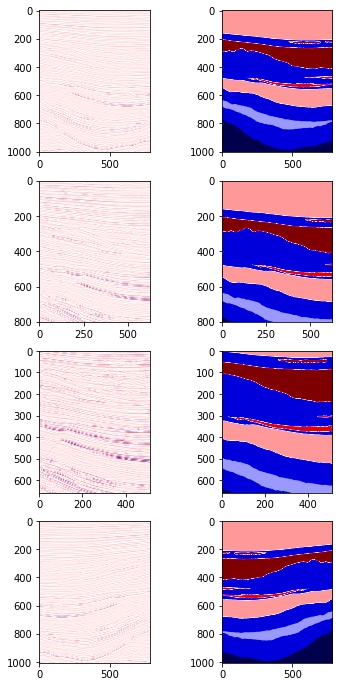

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(6,12))

print(data_train_subframes.shape)

ax[0][0].imshow(data_train_parihaka[:,:,200], cmap='seismic')
ax[0][1].imshow(label_train_parihaka[:,:,200], cmap='seismic')
ax[1][0].imshow(data_train_subframes[:,:,200,0], cmap='seismic')
ax[1][1].imshow(label_train_subframes[:,:,200,0], cmap='seismic')
ax[2][0].imshow(data_train_shear[:,:,200], cmap='seismic')
ax[2][1].imshow(label_train_shear[:,:,200], cmap='seismic')
ax[3][0].imshow(data_train_flip[:,:,200], cmap='seismic')
ax[3][1].imshow(label_train_flip[:,:,200], cmap='seismic')

## Data Preparation and Pre-processing

### Pre-processing (before any augmentation)

In [14]:
def gain(data, dt=3e-3, parameters=0.8):
    nt,nx = data.shape
    dout = np.zeros(data.shape)
    L = parameters/dt+1
    L = np.floor(L/2)
    h = triang(2*L+1)
    shaped_h  = h.reshape(len(h),1)
    for k in range(nx):
        aux = data[:,k]
        e = aux**2
        shaped_e = e.reshape(len(e),1)
        rms = np.sqrt(conv2(shaped_e,shaped_h,"same"))
        epsi = 1e-10*max(rms)
        op = rms/(rms**2+epsi)
        op = op.reshape(len(op),)
        dout[:,k] = data[:,k]*op
    for k in range(nx):
        aux = dout[:,k]
        amax = np.sqrt(sum(aux**2)/nt)
        dout[:,k] = dout[:,k]/amax
    return dout

In [9]:
pari_gain = np.empty(pari_data.shape)
for i in tqdm(range(0, 590)):
  pari_gain[:,:,i] = gain(pari_data[:,:,i])

  0%|          | 0/590 [00:00<?, ?it/s]

In [ ]:
#np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_gain.npz', pari_gain=pari_gain)
pari_gain = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_gain.npz')['pari_gain']
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(pari_gain[:,:,200], cmap='seismic')
ax[1].imshow(pari_data[:,:,200], cmap='seismic')
print(pari_gain.shape)

### Data augmentation

In [6]:
# Since test set from original dataset is unlabeled, draw test set from "train set" of original dataset
split = train_test_split(np.swapaxes(pari_gain, 0, 2), np.swapaxes(pari_label, 0, 2), test_size=0.1, shuffle=True)
data_train, data_test, label_train, label_test = [np.swapaxes(arr, 0, 2) for arr in split]

In [12]:
print(data_train.shape, data_test.shape, label_train.shape, label_test.shape)

(1006, 782, 531) (1006, 782, 59) (1006, 782, 531) (1006, 782, 59)


In [19]:
pari_shear = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_shear.npz')
data_shear, label_shear = pari_shear['data_shear'], pari_shear['label_shear']
#data_shear = transform_shear(data_train)
#label_shear = transform_shear(label_train)

print(data_shear.shape, label_shear.shape)

(658, 512, 531) (658, 512, 531)


In [14]:
np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_shear.npz', data_shear=data_shear, label_shear=label_shear)

In [17]:
%reset_selective data_shear
%reset_selective label_shear

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [15]:
data_vanilla_subframes = transform_subframes(data_train)
data_vanilla_flip = transform_flip(data_train)
label_vanilla_subframes = transform_subframes(label_train)
label_vanilla_flip = transform_flip(label_train)

In [20]:
data_shear_subframes = transform_subframes(data_shear)
data_shear_flip = transform_flip(data_shear)
label_shear_subframes = transform_subframes(label_shear)
label_shear_flip = transform_flip(label_shear)

In [16]:
np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/vanilla_transforms.npz', data_subframes=data_vanilla_subframes,
                    data_flip=data_vanilla_flip, label_subframes=label_vanilla_subframes, label_flip=label_vanilla_flip)

In [21]:
np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/shear_transforms.npz', data_subframes=data_shear_subframes,
                    data_flip=data_shear_flip, label_subframes=label_shear_subframes, label_flip=label_shear_flip)

In [18]:
%reset_selective data_vanilla_subframes
%reset_selective data_vanilla_flip
%reset_selective label_vanilla_subframes
%reset_selective label_vanilla_flip

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [24]:
data_vanilla_diag = transform_diag(data_train)
data_vanilla_ortho = transform_ortho(data_train)
label_vanilla_diag = transform_diag(label_train)
label_vanilla_ortho = transform_ortho(label_train)

In [25]:
np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/vanilla_directional.npz', data_diag=data_vanilla_diag,
                    data_ortho=data_vanilla_ortho, label_diag=label_vanilla_diag, label_ortho=label_vanilla_ortho)

In [26]:
data_shear_ortho = transform_ortho(data_shear)
label_shear_ortho = transform_ortho(label_shear)

In [27]:
np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/shear_directional.npz',
                    data_ortho=data_shear_ortho, label_ortho=label_shear_ortho)

### Combining augmented data
**Unmodified/vanilla**
- Diagonal transform
- Orthogonal transform
- Flip transform
- Subframes transform

**Sheared**
- Diagonal transform
- Orthogonal transform
- Flip transform
- Subframes transform

In [2]:
"""
pari_label = np.load('/content/drive/MyDrive/CS230 Project/Dataset /labels_train.npz',  
               allow_pickle=True, mmap_mode = 'r')['labels']
pari_gain = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_gain.npz')['pari_gain']
split = train_test_split(np.swapaxes(pari_gain, 0, 2), np.swapaxes(pari_label, 0, 2), test_size=0.1, shuffle=True)
data_train, data_test, label_train, label_test = [np.swapaxes(arr, 0, 2) for arr in split]

pari_directional = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/vanilla_directional.npz')
data_diag, data_ortho, label_diag, label_ortho = [pari_directional[key] for key in ['data_diag', 'data_ortho', 'label_diag', 'label_ortho']]
"""
pari_transforms = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/vanilla_transforms.npz')
data_subframes = pari_transforms['data_subframes']
data_flip = pari_transforms['data_flip']
label_subframes = pari_transforms['label_subframes']
label_flip = pari_transforms['label_flip']

In [4]:
#print(data_train.shape, data_diag.shape, data_ortho.shape)
#print(data_train.shape[-1] + data_diag.shape[-1] + data_ortho.shape[-1])
#print(data_vanilla_flip.shape, data_vanilla_subframes.shape)
print(data_subframes[:,:,:,0].shape)

(804, 625, 531)


### Post-augmentation processing

In [16]:
def input_prep(data_cubes, label_cubes):
  preprocessed_data = []
  preprocessed_labels = []
  for cube_index in range(len(data_cubes)):
    data_cube = data_cubes[cube_index]
    label_cube = label_cubes[cube_index]
    n_slices = data_cube.shape[-1]
    for i in tqdm(range(0, n_slices)): #reshaping the images into appropriate sizes 
      img = data_cube[:, :, i]
      label = label_cube[:, :, i]

      img = np.expand_dims(img, axis=2).astype('float32')
      label = np.expand_dims(label, axis=2).astype('float32')

      img = cv2.resize(img, (128, 128))
      label = cv2.resize(label, (128, 128))

      img = img/np.amax(img)
      img = np.clip(img, 0, 255)
      img = (img*255).astype(int)

      img = img/255.

      img = cv2.merge([img,img,img])

      preprocessed_data.append(img) 
      preprocessed_labels.append(label)

  return preprocessed_data, preprocessed_labels

"""
preprocessed_data, preprocessed_labels = input_prep(
    [data_subframes[:,:,:,0], data_subframes[:,:,:,1], data_subframes[:,:,:,2], data_subframes[:,:,:,3], data_flip],
    [label_subframes[:,:,:,0], label_subframes[:,:,:,1], label_subframes[:,:,:,2], label_subframes[:,:,:,3], label_flip])
"""

'\npreprocessed_data, preprocessed_labels = input_prep(\n    [data_subframes[:,:,:,0], data_subframes[:,:,:,1], data_subframes[:,:,:,2], data_subframes[:,:,:,3], data_flip],\n    [label_subframes[:,:,:,0], label_subframes[:,:,:,1], label_subframes[:,:,:,2], label_subframes[:,:,:,3], label_flip])\n'

In [7]:
print('Data: After', np.array(preprocessed_data).shape)
print('Labels: After', np.array(preprocessed_labels).shape)
# First 531: raw data, next 250: diagonal, final 531: orthogonal
#np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_inputs_1.npz', data=preprocessed_data, labels=preprocessed_labels)
# Each of first 4 sets of 531: subframes, final 531: flipped
#np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_inputs_2.npz', data=preprocessed_data, labels=preprocessed_labels)

Data: After (2655, 128, 128, 3)
Labels: After (2655, 128, 128)


In [7]:
# First 531: raw data, next 250: diagonal, final 531: orthogonal
inputs_1 = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_inputs_1.npz')
# Each of first 4 sets of 531: subframes, final 531: flipped
inputs_2 = np.load('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/pari_inputs_2.npz')
data = np.concatenate((inputs_1['data'], inputs_2['data']), axis=0)
labels = np.concatenate((inputs_1['labels'], inputs_2['labels']), axis=0)

(3967, 128, 128, 3) (3967, 128, 128)


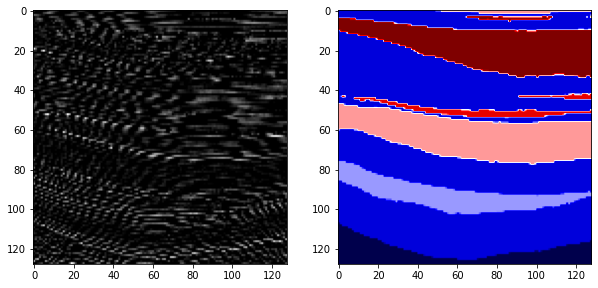

In [17]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(data[3040,:,:,:], cmap='seismic')
ax[1].imshow(labels[3040,:,:], cmap='seismic')
print(data.shape, labels.shape)

## Training (Non-Transfer)

In [8]:
ACTIVATION = 'relu'
ACTIVATION_OUT = 'softmax'
initializer = 'he_normal'
input_size = (128, 128, 3)
N_classes = 7

In [9]:
def UNet1(input_size, N_CLASSES, activation_name, initialization_name, DropoutRatio = 0.5): 
  # Encoder

  # Block encoder 1
  inputs = Input(shape=input_size)
  conv_enc_1 = Conv2D(64, 3, activation = ACTIVATION, padding='same', kernel_initializer=initializer)(inputs)
  conv_enc_1 = BatchNormalization()(conv_enc_1)
  conv_enc_1 = Conv2D(64, 3, activation = ACTIVATION, padding='same', kernel_initializer=initializer)(conv_enc_1)
  conv_enc_1 = BatchNormalization()(conv_enc_1)
  conv_enc_1 = Activation(ACTIVATION)(conv_enc_1)

  # Block encoder 2
  max_pool_enc_2 = MaxPooling2D(pool_size=(2, 2))(conv_enc_1)
  max_pool_enc_2 = Dropout(DropoutRatio/2)(max_pool_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_2)
  conv_enc_2 = BatchNormalization()(conv_enc_2)
  conv_enc_2 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_2)
  conv_enc_2 = BatchNormalization()(conv_enc_2)
  conv_enc_2 = Activation(ACTIVATION)(conv_enc_2)

  # Block  encoder 3
  max_pool_enc_3 = MaxPooling2D(pool_size=(2, 2))(conv_enc_2)
  max_pool_enc_3 = Dropout(DropoutRatio)(max_pool_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_3)
  conv_enc_3 = BatchNormalization()(conv_enc_3)
  conv_enc_3 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_3)
  conv_enc_3 = BatchNormalization()(conv_enc_3)
  conv_enc_3 = Activation(ACTIVATION)(conv_enc_3)

  # Block  encoder 4
  max_pool_enc_4 = MaxPooling2D(pool_size=(2, 2))(conv_enc_3)
  max_pool_enc_4 = Dropout(DropoutRatio)(max_pool_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(max_pool_enc_4)
  conv_enc_4 = BatchNormalization()(conv_enc_4)
  conv_enc_4 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_enc_4)
  conv_enc_4 = BatchNormalization()(conv_enc_4)
  conv_enc_4 = Activation(ACTIVATION)(conv_enc_4)
  #

  # ----------- #
  maxpool = MaxPooling2D(pool_size=(2, 2))(conv_enc_4)
  maxpool = Dropout(DropoutRatio)(maxpool)
  conv = Conv2D(1024, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(maxpool)
  conv = BatchNormalization()(conv)
  conv = Conv2D(1024, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv)
  conv = BatchNormalization()(conv)
  conv = Activation(ACTIVATION)(conv)

  # ----------- #

  # Decoder

  # Block decoder 1
  up_dec_1 = Conv2D(512, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv))
  merge_dec_1 = concatenate([conv_enc_4, up_dec_1], axis = 3)
  merge_dec_1 = Dropout(DropoutRatio)(merge_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_1)
  conv_dec_1 = BatchNormalization()(conv_dec_1)
  conv_dec_1 = Conv2D(512, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_1)
  conv_dec_1 = BatchNormalization()(conv_dec_1)
  conv_dec_1 = Activation(ACTIVATION)(conv_dec_1)

  # Block decoder 2
  up_dec_2 = Conv2D(256, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_1))
  merge_dec_2 = concatenate([conv_enc_3, up_dec_2], axis = 3)
  merge_dec_2 = Dropout(DropoutRatio)(merge_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_2)
  conv_dec_2 = BatchNormalization()(conv_dec_2)
  conv_dec_2 = Conv2D(256, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_2)
  conv_dec_2 = BatchNormalization()(conv_dec_2)
  conv_dec_2 = Activation(ACTIVATION)(conv_dec_2)

  # Block decoder 3
  up_dec_3 = Conv2D(128, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_2))
  merge_dec_3 = concatenate([conv_enc_2, up_dec_3], axis = 3)
  merge_dec_3 = Dropout(DropoutRatio)(merge_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_3)
  conv_dec_3 = BatchNormalization()(conv_dec_3)
  conv_dec_3 = Conv2D(128, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_3)
  conv_dec_3 = BatchNormalization()(conv_dec_3)
  conv_dec_3 = Activation(ACTIVATION)(conv_dec_3)

  # Block decoder 4
  up_dec_4 = Conv2D(64, 2, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(UpSampling2D(size = (2,2))(conv_dec_3))
  merge_dec_4 = concatenate([conv_enc_1, up_dec_4], axis = 3)
  merge_dec_4 = Dropout(DropoutRatio)(merge_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(merge_dec_4)
  conv_dec_4 = BatchNormalization()(conv_dec_4)
  conv_dec_4 = Conv2D(64, 3, activation = ACTIVATION, padding = 'same', kernel_initializer = initializer)(conv_dec_4)
  conv_dec_4 = BatchNormalization()(conv_dec_4)
  conv_dec_4 = Activation(ACTIVATION)(conv_dec_4)

  #last = tf.keras.layers.Conv2DTranspose(1, 3, strides=1, padding='same')(conv_dec_4) 
  output = Conv2D(N_CLASSES, 1, activation = ACTIVATION_OUT)(conv_dec_4)

  # Create the model. Here we initialize the Keras model instance. We use this later to train/test. 
  model = tf.keras.Model(inputs = inputs, outputs = output)

  return inputs, output

In [26]:
inputs, output = UNet1(input_size, N_CLASSES = N_classes, activation_name = ACTIVATION, initialization_name= initializer)
pari_model_unet = tf.keras.Model(inputs = inputs, outputs = output)
print(pari_model_unet.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 128, 128, 64  256        ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

In [11]:
def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=7))
    y_pred_f = K.flatten(y_pred)
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

In [12]:
model_path="{}.h5".format('fixed_model_unet_1') #hdf5
checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only = False)

In [27]:
pari_model_unet.compile(optimizer=Adam(learning_rate=0.0001), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy' , dice_coef])

In [15]:
print(data_test.shape, label_test.shape)

(1006, 782, 59) (1006, 782, 59)


In [17]:
test_gain = np.empty(data_test.shape)
for i in tqdm(range(0, 59)):
  test_gain[:,:,i] = gain(data_test[:,:,i])

pp_test_data, pp_test_labels = input_prep([test_gain], [label_test])

  0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

In [22]:
np.savez_compressed('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/preprocessed_test.npz', data=np.array(pp_test_data), labels=np.array(pp_test_labels))

In [24]:
pp_test_data, pp_test_labels = np.array(pp_test_data), np.array(pp_test_labels)

In [28]:
model_history = pari_model_unet.fit(x=data, y=labels, validation_data=(pp_test_data, pp_test_labels), epochs=100, callbacks=[checkpoint])

Epoch 1/100
124/124 [==============================] - ETA: 0s - loss: 1.4433 - accuracy: 0.4993 - dice_coef: 0.3833
Epoch 00001: val_loss improved from inf to 5.30370, saving model to fixed_model_unet_1.h5
124/124 [==============================] - 44s 335ms/step - loss: 1.4433 - accuracy: 0.4993 - dice_coef: 0.3833 - val_loss: 5.3037 - val_accuracy: 0.4855 - val_dice_coef: 0.4755
Epoch 2/100
124/124 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.7551 - dice_coef: 0.6533
Epoch 00002: val_loss did not improve from 5.30370
124/124 [==============================] - 37s 299ms/step - loss: 0.6333 - accuracy: 0.7551 - dice_coef: 0.6533 - val_loss: 6.2554 - val_accuracy: 0.4208 - val_dice_coef: 0.4187
Epoch 3/100
124/124 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8193 - dice_coef: 0.7539
Epoch 00003: val_loss improved from 5.30370 to 3.14742, saving model to fixed_model_unet_1.h5
124/124 [==============================] - 38s 308ms/step 

In [30]:
# Function to plot our metrics 
def PlotHistory(_model, feature, start_epoch = 0, path_file = None):
    val = "val_" + feature
    
    plt.xlabel('Epoch Number' + str(start_epoch))
    plt.ylabel(feature)
    plt.plot(_model.history[feature][start_epoch:])
    plt.plot(_model.history[val][start_epoch:])
    plt.title(val)
    plt.legend(["train_"+feature, val]) 

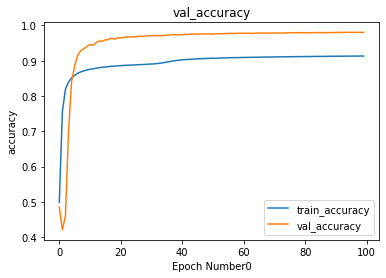

In [31]:
PlotHistory(model_history, 'accuracy')

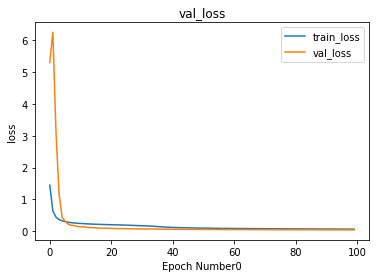

In [32]:
PlotHistory(model_history, 'loss')

In [34]:
pari_model_unet.save('/content/drive/MyDrive/CS230 Project/Adam Data Augmentation/unet_vanilla')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CS230 Project/Adam Data Augmentation/unet_vanilla/assets
